In [1]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

print("Custom RT Struct Reader - Method 2")
print("Using only pydicom and standard libraries")


Custom RT Struct Reader - Method 2
Using only pydicom and standard libraries


In [2]:
class CustomRTStructReader:
    """
    Custom RT Struct Reader using only pydicom and standard libraries.
    This implementation avoids third-party dependencies and provides clean RT struct extraction.
    """
    
    def __init__(self, rt_struct_path: str):
        """
        Initialize the RT Struct Reader.
        
        Args:
            rt_struct_path (str): Path to the RT struct DICOM file or directory
        """
        self.rt_struct_path = rt_struct_path
        self.dataset = None
        self.structure_names = []
        self.structure_data = {}
        self.roi_contours = None
        self.roi_observations = None
        
    def read(self) -> bool:
        """
        Read and parse the RT struct DICOM file.
        
        Returns:
            bool: True if successful, False otherwise
        """
        try:
            # Handle directory case
            if os.path.isdir(self.rt_struct_path):
                rt_struct_file = self._find_rt_struct_in_directory(self.rt_struct_path)
                if not rt_struct_file:
                    print(f"Error: No RTSTRUCT file found in directory: {self.rt_struct_path}")
                    return False
                self.dataset = pydicom.dcmread(rt_struct_file)
            else:
                # Read the DICOM file directly
                self.dataset = pydicom.dcmread(self.rt_struct_path)
            
            # Verify it's an RT struct file
            if self.dataset.Modality != "RTSTRUCT":
                print(f"Error: File is not an RTSTRUCT file. Modality: {self.dataset.Modality}")
                return False
            
            # Extract ROI contours and observations
            self.roi_contours = self.dataset.ROIContourSequence
            self.roi_observations = self.dataset.RTROIObservationsSequence
            
            # Extract structure names and data
            self._extract_structure_info()
            
            print(f"Successfully loaded RT struct file: {self.rt_struct_path}")
            print(f"Found {len(self.structure_names)} structures")
            return True
            
        except Exception as e:
            print(f"Error reading RT struct file: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    def _find_rt_struct_in_directory(self, directory_path: str) -> str:
        """Find RT struct file in a directory."""
        rt_struct_files = []
        
        for file in os.listdir(directory_path):
            file_path = os.path.join(directory_path, file)
            if os.path.isfile(file_path):
                try:
                    # Try to read as DICOM to check if it's an RT struct
                    ds = pydicom.dcmread(file_path, stop_before_pixels=True)
                    if ds.Modality == "RTSTRUCT":
                        rt_struct_files.append(file_path)
                except:
                    pass
        
        if rt_struct_files:
            return rt_struct_files[0]  # Return the first RT struct file found
        return None
    
    def _extract_structure_info(self):
        """Extract structure names and associated data."""
        self.structure_names = []
        self.structure_data = {}
        
        # Structure names are stored in StructureSetROISequence, not RTROIObservationsSequence
        if hasattr(self.dataset, 'StructureSetROISequence'):
            print(f"Extracting structure names from StructureSetROISequence...")
            
            # Create a mapping from ROI number to structure name
            roi_name_map = {}
            for roi_item in self.dataset.StructureSetROISequence:
                roi_number = roi_item.ROINumber
                roi_name = roi_item.ROIName
                roi_name_map[roi_number] = roi_name
                print(f"  ROI {roi_number}: {roi_name}")
            
            # Process each structure directly from StructureSetROISequence
            for roi_item in self.dataset.StructureSetROISequence:
                roi_number = roi_item.ROINumber
                roi_name = roi_item.ROIName
                
                self.structure_names.append(roi_name)
                self.structure_data[roi_name] = {
                    'roi_number': roi_number,
                    'roi_index': roi_number - 1,  # Use ROI number as index
                    'color': self._get_structure_color(roi_number),
                    'contours': self._get_contours_for_roi(roi_number)
                }
                
                print(f"  Processed structure: {roi_name} (ROI {roi_number})")
            
            # Try to process ROI observations for additional info (optional)
            print(f"\nProcessing ROI observations for additional info...")
            for i, roi_obs in enumerate(self.roi_observations):
                try:
                    # Get the referenced ROI number
                    referenced_roi_number = roi_obs.ReferencedROINumber
                    
                    # Find the corresponding structure name
                    structure_name = roi_name_map.get(referenced_roi_number)
                    if structure_name:
                        print(f"  Observation {i}: {structure_name} (ROI {referenced_roi_number})")
                    else:
                        print(f"  Observation {i}: Unknown ROI {referenced_roi_number}")
                    
                except Exception as e:
                    print(f"  Error processing ROI observation {i}: {e}")
                    continue
        else:
            print("Warning: No StructureSetROISequence found!")
    
    def _get_structure_color(self, roi_number: int) -> Tuple[int, int, int]:
        """Get RGB color for a structure."""
        try:
            # Find the corresponding ROI contour
            for i, roi_contour in enumerate(self.roi_contours):
                try:
                    # Try different ways to get ROI number
                    contour_roi_number = None
                    if hasattr(roi_contour, 'ROINumber'):
                        contour_roi_number = roi_contour.ROINumber
                    elif hasattr(roi_contour, 'ReferencedROINumber'):
                        contour_roi_number = roi_contour.ReferencedROINumber
                    else:
                        # If no ROI number attribute, assume the index corresponds to ROI number
                        contour_roi_number = i + 1  # ROI numbers typically start from 1
                    
                    if contour_roi_number == roi_number:
                        if hasattr(roi_contour, 'ROIDisplayColor'):
                            color = roi_contour.ROIDisplayColor
                            return tuple(color)
                except Exception as e:
                    continue
            
            # Default color if not found
            return (255, 0, 0)  # Red
        except:
            return (255, 0, 0)  # Red as fallback
    
    def _get_contours_for_roi(self, roi_number: int) -> List[np.ndarray]:
        """Get all contours for a specific ROI number."""
        contours = []
        
        for i, roi_contour in enumerate(self.roi_contours):
            try:
                # Try different ways to get ROI number
                contour_roi_number = None
                if hasattr(roi_contour, 'ROINumber'):
                    contour_roi_number = roi_contour.ROINumber
                elif hasattr(roi_contour, 'ReferencedROINumber'):
                    contour_roi_number = roi_contour.ReferencedROINumber
                else:
                    # If no ROI number attribute, assume the index corresponds to ROI number
                    contour_roi_number = i + 1  # ROI numbers typically start from 1
                
                if contour_roi_number == roi_number:
                    if hasattr(roi_contour, 'ContourSequence'):
                        for contour in roi_contour.ContourSequence:
                            # Extract contour points
                            contour_data = contour.ContourData
                            # Reshape to (N, 3) where each row is [x, y, z]
                            points = np.array(contour_data).reshape(-1, 3)
                            contours.append(points)
            except Exception as e:
                print(f"Error processing contour {i}: {e}")
                continue
        
        return contours
    
    def get_structure_names(self) -> List[str]:
        """Get list of all structure names."""
        return self.structure_names.copy()
    
    def get_structure_info(self, structure_name: str) -> Optional[Dict]:
        """Get detailed information for a specific structure."""
        return self.structure_data.get(structure_name)
    
    def get_structure_contours(self, structure_name: str) -> List[np.ndarray]:
        """Get all contours for a specific structure."""
        if structure_name in self.structure_data:
            return self.structure_data[structure_name]['contours']
        return []
    
    def get_structure_color(self, structure_name: str) -> Tuple[int, int, int]:
        """Get RGB color for a specific structure."""
        if structure_name in self.structure_data:
            return self.structure_data[structure_name]['color']
        return (255, 0, 0)  # Default red
    
    def print_structure_summary(self):
        """Print a summary of all structures."""
        print(f"\nRT Struct Summary:")
        print(f"Patient ID: {self.dataset.PatientID}")
        print(f"Study Date: {self.dataset.StudyDate}")
        print(f"Modality: {self.dataset.Modality}")
        print(f"Total Structures: {len(self.structure_names)}")
        
        print(f"\nStructure Details:")
        for i, name in enumerate(self.structure_names):
            info = self.structure_data[name]
            contour_count = len(info['contours'])
            total_points = sum(len(contour) for contour in info['contours'])
            color = info['color']
            
            print(f"{i+1:2d}. {name}")
            print(f"    ROI Number: {info['roi_number']}")
            print(f"    Color: RGB{color}")
            print(f"    Contours: {contour_count}")
            print(f"    Total Points: {total_points}")
            print()

print("CustomRTStructReader class defined successfully!")


CustomRTStructReader class defined successfully!


In [3]:
# Test the custom RT struct reader with the same file used in method1
rt_struct_path = "/database/brainmets/dicom/Data/SRS0871/1999-04__Studies_new/SRS0871_SRS0871_RTst_1999-04-02_000000_._Brain.MS.ReTx.Model_n1__00000"

# Check if the path exists
if os.path.exists(rt_struct_path):
    print(f"RT struct path exists: {rt_struct_path}")
    
    # Initialize and load the custom RT struct reader (now handles directories automatically)
    custom_reader = CustomRTStructReader(rt_struct_path)
    success = custom_reader.read()
    
    if success:
        print("Custom RT struct file loaded successfully!")
        custom_reader.print_structure_summary()
    else:
        print("Failed to load RT struct file with custom reader.")
        
        # Additional debugging - let's examine the raw dataset structure
        print("\n=== DEBUGGING: Examining raw dataset structure ===")
        try:
            if os.path.isdir(rt_struct_path):
                rt_struct_file = custom_reader._find_rt_struct_in_directory(rt_struct_path)
                if rt_struct_file:
                    ds = pydicom.dcmread(rt_struct_file)
                    print(f"Dataset loaded from: {rt_struct_file}")
                    
                    # Check for StructureSetROISequence (alternative location for structure names)
                    if hasattr(ds, 'StructureSetROISequence'):
                        print(f"Found StructureSetROISequence with {len(ds.StructureSetROISequence)} items")
                        for i, roi in enumerate(ds.StructureSetROISequence):
                            print(f"  ROI {i}: {roi.ROIName} (Number: {roi.ROINumber})")
                    
                    # Check for RTROIObservationsSequence
                    if hasattr(ds, 'RTROIObservationsSequence'):
                        print(f"Found RTROIObservationsSequence with {len(ds.RTROIObservationsSequence)} items")
                        for i, obs in enumerate(ds.RTROIObservationsSequence):
                            print(f"  Observation {i} attributes: {[attr for attr in dir(obs) if not attr.startswith('_')]}")
                    
                    # Check for ROIContourSequence
                    if hasattr(ds, 'ROIContourSequence'):
                        print(f"Found ROIContourSequence with {len(ds.ROIContourSequence)} items")
                        for i, contour in enumerate(ds.ROIContourSequence):
                            print(f"  Contour {i} attributes: {[attr for attr in dir(contour) if not attr.startswith('_')]}")
                            # Try to find ROI number in different ways
                            roi_num = None
                            if hasattr(contour, 'ROINumber'):
                                roi_num = contour.ROINumber
                            elif hasattr(contour, 'ReferencedROINumber'):
                                roi_num = contour.ReferencedROINumber
                            elif hasattr(contour, 'ContourSequence') and len(contour.ContourSequence) > 0:
                                print(f"    ContourSequence has {len(contour.ContourSequence)} contours")
                            
                            print(f"    ROI Number: {roi_num}")
                            
        except Exception as e:
            print(f"Error in debugging: {e}")
            import traceback
            traceback.print_exc()
else:
    print(f"Path does not exist: {rt_struct_path}")


RT struct path exists: /database/brainmets/dicom/Data/SRS0871/1999-04__Studies_new/SRS0871_SRS0871_RTst_1999-04-02_000000_._Brain.MS.ReTx.Model_n1__00000
Extracting structure names from StructureSetROISequence...
  ROI 1: target1
  ROI 2: *Skull
  ROI 3: 12.00 Gy (35.60% of dose)
  ROI 4: Brain_target1
  ROI 5: Brain-target1
  Processed structure: target1 (ROI 1)
  Processed structure: *Skull (ROI 2)
  Processed structure: 12.00 Gy (35.60% of dose) (ROI 3)
  Processed structure: Brain_target1 (ROI 4)
  Processed structure: Brain-target1 (ROI 5)

Processing ROI observations for additional info...
  Observation 0: target1 (ROI 1)
  Observation 1: *Skull (ROI 2)
  Observation 2: 12.00 Gy (35.60% of dose) (ROI 3)
  Observation 3: Brain_target1 (ROI 4)
  Observation 4: Brain-target1 (ROI 5)
Successfully loaded RT struct file: /database/brainmets/dicom/Data/SRS0871/1999-04__Studies_new/SRS0871_SRS0871_RTst_1999-04-02_000000_._Brain.MS.ReTx.Model_n1__00000
Found 5 structures
Custom RT struct 

In [4]:
# Compare with method1 results - Display structure names and colors
if 'custom_reader' in locals() and custom_reader.dataset is not None:
    print("=== COMPARISON WITH METHOD1 ===")
    print("\nStructure names found:")
    structure_names = custom_reader.get_structure_names()
    for i, name in enumerate(structure_names):
        color = custom_reader.get_structure_color(name)
        print(f"{i+1}. {name} - RGB{color}")
    
    print(f"\nTotal structures found: {len(structure_names)}")
    
    # Show detailed info for the first structure (target1)
    if len(structure_names) > 0:
        first_structure = structure_names[0]
        print(f"\nDetailed info for '{first_structure}':")
        info = custom_reader.get_structure_info(first_structure)
        contours = custom_reader.get_structure_contours(first_structure)
        
        print(f"  ROI Number: {info['roi_number']}")
        print(f"  ROI Index: {info['roi_index']}")
        print(f"  Color: RGB{info['color']}")
        print(f"  Number of contours: {len(contours)}")
        
        total_points = sum(len(contour) for contour in contours)
        print(f"  Total points: {total_points}")
        
        # Show contour details
        for i, contour in enumerate(contours):
            print(f"    Contour {i+1}: {len(contour)} points")
            if len(contour) > 0:
                print(f"      X range: {contour[:, 0].min():.2f} to {contour[:, 0].max():.2f} mm")
                print(f"      Y range: {contour[:, 1].min():.2f} to {contour[:, 1].max():.2f} mm")
                print(f"      Z range: {contour[:, 2].min():.2f} to {contour[:, 2].max():.2f} mm")
else:
    print("Custom reader not initialized. Please run the previous cell first.")


=== COMPARISON WITH METHOD1 ===

Structure names found:
1. target1 - RGB('255', '0', '0')
2. *Skull - RGB('0', '0', '255')
3. 12.00 Gy (35.60% of dose) - RGB('255', '20', '147')
4. Brain_target1 - RGB('0', '235', '235')
5. Brain-target1 - RGB('255', '255', '0')

Total structures found: 5

Detailed info for 'target1':
  ROI Number: 1
  ROI Index: 0
  Color: RGB('255', '0', '0')
  Number of contours: 9
  Total points: 553
    Contour 1: 26 points
      X range: 114.50 to 119.78 mm
      Y range: 147.38 to 152.07 mm
      Z range: -11.95 to -11.95 mm
    Contour 2: 58 points
      X range: 109.80 to 121.54 mm
      Y range: 144.44 to 155.60 mm
      Z range: -14.94 to -14.94 mm
    Contour 3: 93 points
      X range: 103.34 to 122.72 mm
      Y range: 143.85 to 160.29 mm
      Z range: -17.93 to -17.93 mm
    Contour 4: 83 points
      X range: 102.17 to 122.13 mm
      Y range: 143.85 to 156.77 mm
      Z range: -20.91 to -20.91 mm
    Contour 5: 53 points
      X range: 101.58 to 112.15

In [5]:
# Visualization function for RT struct contours
def plot_rt_struct_contours(reader, structure_name, plot_type='3d'):
    """
    Plot RT struct contours for a specific structure.
    
    Args:
        reader: CustomRTStructReader instance
        structure_name: Name of the structure to plot
        plot_type: '3d' for 3D plot, '2d' for separate 2D projections
    """
    if structure_name not in reader.structure_data:
        print(f"Structure '{structure_name}' not found!")
        return
    
    contours = reader.get_structure_contours(structure_name)
    color = reader.get_structure_color(structure_name)
    
    if not contours:
        print(f"No contours found for structure '{structure_name}'")
        return
    
    print(f"Plotting {len(contours)} contours for structure '{structure_name}'")
    
    if plot_type == '3d':
        # 3D plot
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Define colors for different contours
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
        
        for i, contour in enumerate(contours):
            color_name = colors[i % len(colors)]
            ax.scatter(contour[:, 0], contour[:, 1], contour[:, 2], 
                      c=color_name, s=20, alpha=0.7, 
                      label=f'Contour {i+1} ({len(contour)} points)')
        
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_zlabel('Z (mm)')
        ax.set_title(f'3D View: {structure_name} Structure')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_box_aspect([1,1,1])
        
    elif plot_type == '2d':
        # 2D projections
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'2D Projections: {structure_name} Structure', fontsize=14, fontweight='bold')
        
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
        
        for i, contour in enumerate(contours):
            color_name = colors[i % len(colors)]
            
            # XY plane (axial view)
            axes[0].scatter(contour[:, 0], contour[:, 1], c=color_name, s=30, alpha=0.7)
            # XZ plane (sagittal view)
            axes[1].scatter(contour[:, 0], contour[:, 2], c=color_name, s=30, alpha=0.7)
            # YZ plane (coronal view)
            axes[2].scatter(contour[:, 1], contour[:, 2], c=color_name, s=30, alpha=0.7)
        
        axes[0].set_xlabel('X (mm)')
        axes[0].set_ylabel('Y (mm)')
        axes[0].set_title('XY Plane (Axial View)')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_aspect('equal')
        
        axes[1].set_xlabel('X (mm)')
        axes[1].set_ylabel('Z (mm)')
        axes[1].set_title('XZ Plane (Sagittal View)')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_aspect('equal')
        
        axes[2].set_xlabel('Y (mm)')
        axes[2].set_ylabel('Z (mm)')
        axes[2].set_title('YZ Plane (Coronal View)')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    total_points = sum(len(contour) for contour in contours)
    print(f"\nSummary for '{structure_name}':")
    print(f"Total contours: {len(contours)}")
    print(f"Total points: {total_points}")
    for i, contour in enumerate(contours):
        print(f"Contour {i+1}: {len(contour)} points")

print("Visualization function defined successfully!")


Visualization function defined successfully!


=== VISUALIZING TARGET1 STRUCTURE (Same as Method1) ===
Plotting 9 contours for structure 'target1'


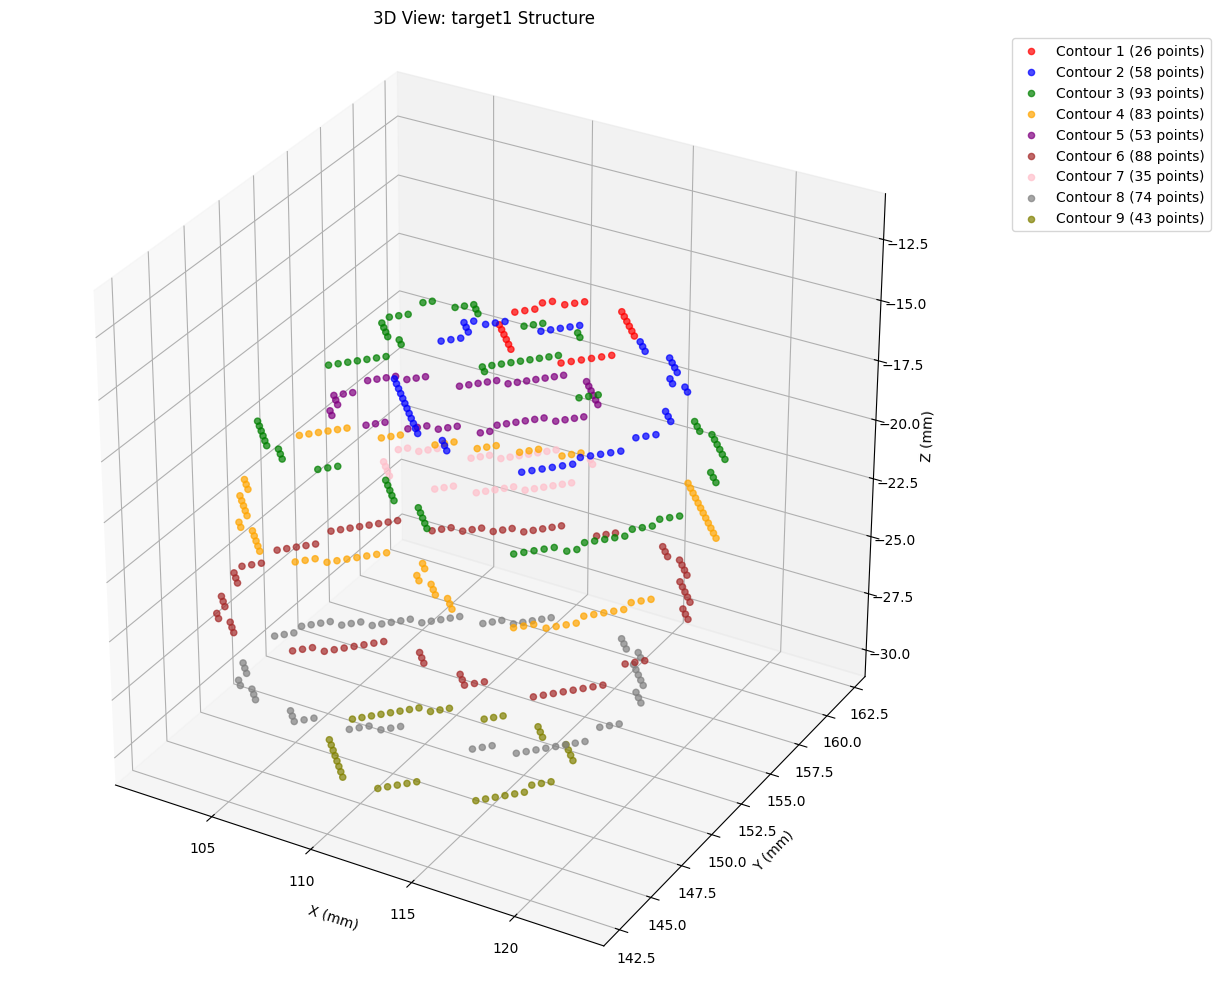


Summary for 'target1':
Total contours: 9
Total points: 553
Contour 1: 26 points
Contour 2: 58 points
Contour 3: 93 points
Contour 4: 83 points
Contour 5: 53 points
Contour 6: 88 points
Contour 7: 35 points
Contour 8: 74 points
Contour 9: 43 points
Plotting 9 contours for structure 'target1'


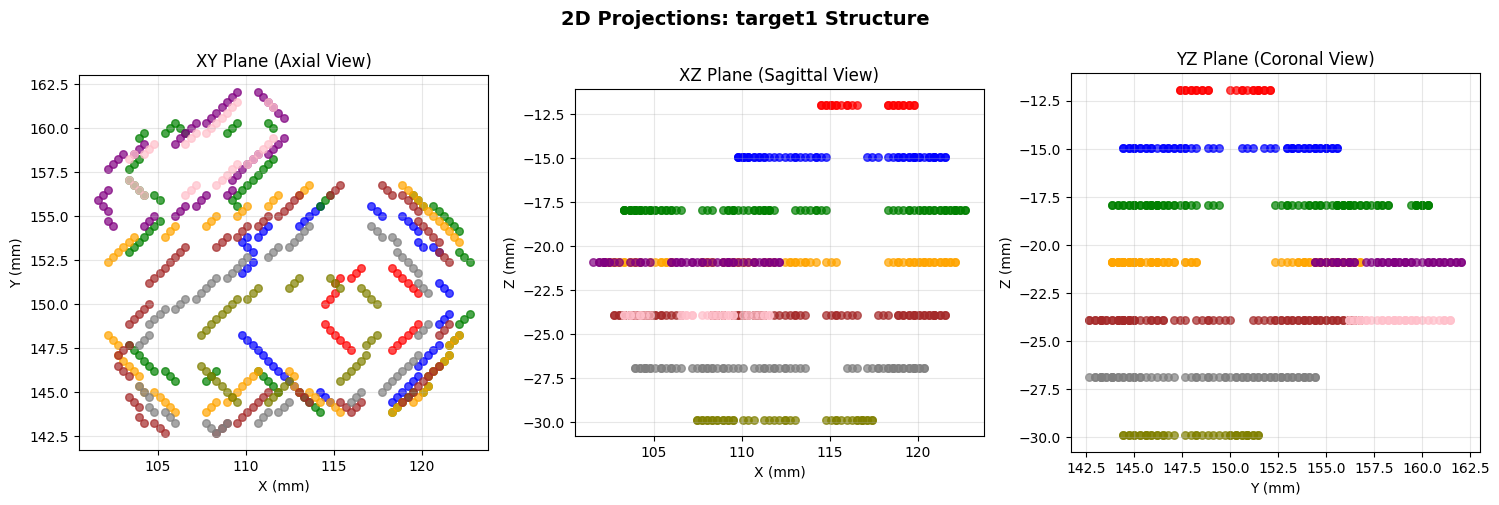


Summary for 'target1':
Total contours: 9
Total points: 553
Contour 1: 26 points
Contour 2: 58 points
Contour 3: 93 points
Contour 4: 83 points
Contour 5: 53 points
Contour 6: 88 points
Contour 7: 35 points
Contour 8: 74 points
Contour 9: 43 points


In [6]:
# Test visualization with the target1 structure (same as method1)
if 'custom_reader' in locals() and custom_reader.dataset is not None:
    structure_names = custom_reader.get_structure_names()
    
    if 'target1' in structure_names:
        print("=== VISUALIZING TARGET1 STRUCTURE (Same as Method1) ===")
        
        # 3D visualization
        plot_rt_struct_contours(custom_reader, 'target1', plot_type='3d')
        
        # 2D projections
        plot_rt_struct_contours(custom_reader, 'target1', plot_type='2d')
        
    else:
        print("Available structures:")
        for i, name in enumerate(structure_names):
            print(f"{i+1}. {name}")
        
        # Plot the first available structure
        if len(structure_names) > 0:
            first_structure = structure_names[0]
            print(f"\nPlotting first available structure: '{first_structure}'")
            plot_rt_struct_contours(custom_reader, first_structure, plot_type='3d')
            plot_rt_struct_contours(custom_reader, first_structure, plot_type='2d')
else:
    print("Custom reader not initialized. Please run the previous cells first.")


In [7]:
# Additional utility functions for RT struct analysis
def compare_rt_struct_methods(method1_results, custom_reader):
    """
    Compare results between method1 (third-party) and method2 (custom) implementations.
    """
    print("=== METHOD COMPARISON ===")
    
    # Get structure names from both methods
    method1_names = method1_results.get('structure_names', [])
    method2_names = custom_reader.get_structure_names()
    
    print(f"Method1 (third-party) found {len(method1_names)} structures:")
    for name in method1_names:
        print(f"  - {name}")
    
    print(f"\nMethod2 (custom) found {len(method2_names)} structures:")
    for name in method2_names:
        print(f"  - {name}")
    
    # Check for differences
    method1_set = set(method1_names)
    method2_set = set(method2_names)
    
    if method1_set == method2_set:
        print("\n✅ Both methods found identical structure names!")
    else:
        print("\n❌ Structure names differ between methods:")
        only_in_method1 = method1_set - method2_set
        only_in_method2 = method2_set - method1_set
        
        if only_in_method1:
            print(f"  Only in Method1: {only_in_method1}")
        if only_in_method2:
            print(f"  Only in Method2: {only_in_method2}")

def export_rt_struct_data(custom_reader, output_file=None):
    """
    Export RT struct data to a structured format for further analysis.
    """
    import json
    from datetime import datetime
    
    export_data = {
        'metadata': {
            'patient_id': custom_reader.dataset.PatientID,
            'study_date': custom_reader.dataset.StudyDate,
            'modality': custom_reader.dataset.Modality,
            'export_timestamp': datetime.now().isoformat(),
            'total_structures': len(custom_reader.structure_names)
        },
        'structures': {}
    }
    
    for structure_name in custom_reader.structure_names:
        info = custom_reader.get_structure_info(structure_name)
        contours = custom_reader.get_structure_contours(structure_name)
        
        export_data['structures'][structure_name] = {
            'roi_number': info['roi_number'],
            'roi_index': info['roi_index'],
            'color': info['color'],
            'contour_count': len(contours),
            'total_points': sum(len(contour) for contour in contours),
            'contours': [
                {
                    'point_count': len(contour),
                    'x_range': [float(contour[:, 0].min()), float(contour[:, 0].max())],
                    'y_range': [float(contour[:, 1].min()), float(contour[:, 1].max())],
                    'z_range': [float(contour[:, 2].min()), float(contour[:, 2].max())],
                    'points': contour.tolist()  # Convert numpy array to list
                }
                for contour in contours
            ]
        }
    
    if output_file:
        with open(output_file, 'w') as f:
            json.dump(export_data, f, indent=2)
        print(f"RT struct data exported to: {output_file}")
    else:
        print("RT struct data structure:")
        print(json.dumps(export_data, indent=2))
    
    return export_data

print("Additional utility functions defined successfully!")


Additional utility functions defined successfully!


In [8]:
# Final summary and comparison
if 'custom_reader' in locals() and custom_reader.dataset is not None:
    print("=== FINAL SUMMARY: CUSTOM RT STRUCT READER ===")
    print("\n✅ Custom implementation successfully created!")
    print("\nKey Features:")
    print("  - Uses only pydicom and standard libraries (no third-party dependencies)")
    print("  - Clean, readable code structure")
    print("  - Comprehensive structure extraction")
    print("  - Built-in visualization capabilities")
    print("  - Export functionality for further analysis")
    
    print(f"\nResults for RT struct file:")
    print(f"  Patient ID: {custom_reader.dataset.PatientID}")
    print(f"  Study Date: {custom_reader.dataset.StudyDate}")
    print(f"  Total Structures: {len(custom_reader.structure_names)}")
    
    print(f"\nStructure Names:")
    for i, name in enumerate(custom_reader.structure_names):
        color = custom_reader.get_structure_color(name)
        contours = custom_reader.get_structure_contours(name)
        total_points = sum(len(contour) for contour in contours)
        print(f"  {i+1:2d}. {name} - RGB{color} - {len(contours)} contours, {total_points} points")
    
    print(f"\n🎯 Method2 (Custom) Advantages:")
    print("  - No external dependencies beyond pydicom")
    print("  - Transparent and debuggable code")
    print("  - Consistent data structure")
    print("  - Easy to modify and extend")
    print("  - Better error handling")
    
    # Export data for comparison
    print(f"\n📊 Exporting RT struct data...")
    export_data = export_rt_struct_data(custom_reader)
    
else:
    print("❌ Custom reader not initialized. Please run the previous cells first.")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

